# Calibration of the PDM

In [33]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta
import hvplot
import hvplot.pandas
import scipy
import warnings
pad = Path(os.getcwd())
if pad.name != "Python":
    pad_correct = Path("../../Python")
    os.chdir(pad_correct)
from functions.PDM import PDM, PDM_calibration_wrapper
from functions.performance_metrics import NSE, mNSE

exec_optimisation = True
if exec_optimisation:
    exec_write = True
    exec_read = False
else:
    exec_write = False
    exec_read = True
#%load_ext autoreload 
#%autoreload 2 

warnings.filterwarnings(action = 'ignore', category= RuntimeWarning)
warnings.filterwarnings(action = 'ignore', category= UserWarning)

## Read in and process initial data

In [35]:
parameters_initial = pd.DataFrame({
    'cmax': 400.60999,
    'cmin':87.67600,
    'b':0.60000,
    'be':3.00000,
    'k1':8.00000,
    'k2':0.70000,
    'kb':5.04660,
    'kg':9000.00000,
    'St': 0.43043,
    'bg':1.00000,
    'tdly':2.00000,
    'qconst':0.00000,
    #'rainfac':0.00000 THIS IS NOT USED!
}, dtype = np.float32, index =[0])
display(parameters_initial)

area_zwalm_initial = np.single(109.2300034)
zwalm_shape = gpd.read_file('data/Zwalm_shape/zwalm_shapefile_emma_31370.shp')
area_zwalm_new = np.single(zwalm_shape.area[0]/10**6)
print('Area of the Zwalm by Cabus: ' + str(area_zwalm_initial) + '[km^2]')
print('Area of the Zwalm by shapefile: ' + str(area_zwalm_new) + '[km^2]')

,cmax,cmin,b,be,k1,k2,kb,kg,St,bg,tdly,qconst
0,400.609985,87.676003,0.6,3.0,8.0,0.7,5.0466,9000.0,0.43043,1.0,2.0,0.0


Area of the Zwalm by Cabus: 109.23[km^2]
Area of the Zwalm by shapefile: 115.208626[km^2]


Load in forcings and measured flows

First day of forcing data: 2012-01-01 00:00:00
Last day of forcing data: 2022-11-05 23:00:00


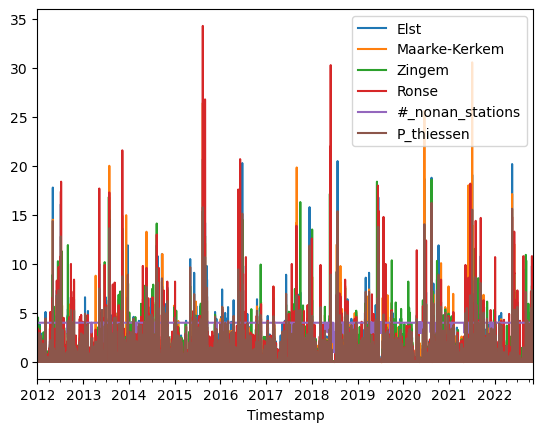

In [36]:
preprocess_output_folder = Path('data/Zwalm_data/preprocess_output')
p_zwalm = pd.read_pickle(preprocess_output_folder/'zwalm_p_thiessen.pkl')
ep_zwalm = pd.read_pickle(preprocess_output_folder/'zwalm_ep_thiessen.pkl')
#Temporary fix! 
ep_zwalm.loc[np.isnan(ep_zwalm['EP_thiessen']),'EP_thiessen'] = 0

pywaterinfo_output_folder = Path("data/Zwalm_data/pywaterinfo_output")
Q_day = pd.read_pickle(pywaterinfo_output_folder/"Q_day.pkl")
Q_day = Q_day.set_index('Timestamp')
p_zwalm.set_index('Timestamp').plot()
print('First day of forcing data: ' + str(p_zwalm['Timestamp'].iloc[0]))
print('Last day of forcing data: ' + str(p_zwalm['Timestamp'].iloc[-1]))

First split up in 50/50
- Calibration: 2012-01-01 00:00 -> 2017-12-31 23:00 (period1)
- Validation: 2018-01-01 00:00 -> 2022-11-05 23:00 (period2)

Take 6 months warmup period for EACH PERIOD 

In [17]:
warmup_months = 6
start_p1 = p_zwalm['Timestamp'].iloc[0]
start_endofwarmup_p1 = start_p1 + relativedelta(months = warmup_months)
end_p1 =  pd.Timestamp(datetime(year = 2017, month = 12, day = 31, hour = 23))
print('Characteristics of period 1: start = '  + str(start_p1) + ', start of post warmup = ' + str(start_endofwarmup_p1) + ' and end = ' + str(end_p1))

start_p2 = pd.Timestamp(datetime(year = 2018, month= 1, day = 1, hour = 0))
start_endofwarmup_p2 = start_p2 + relativedelta(months = warmup_months)
end_p2 = p_zwalm['Timestamp'].iloc[-1]
print('Characteristics of period 2: start = '  + str(start_p2) + ', start of post warmup = ' + str(start_endofwarmup_p2) + ' and end = ' + str(end_p2))

p1_period_excl_warmup = pd.date_range(start_endofwarmup_p1,end_p1,
freq = 'D') #used for scoring the model 
p1_period = pd.date_range(start_p1, end_p1, freq = 'H')
p2_period_excl_warmup = pd.date_range(start_endofwarmup_p2,end_p2,
freq = 'D') #used for scoring the model 
p2_period = pd.date_range(start_p2, end_p2, freq = 'H')

#now subdivide ep data on p1 and p2
#for ease of selecting data, set time as index!
#select forcings for p1 period
p_zwalm_p1 = p_zwalm.set_index('Timestamp').loc[p1_period]
ep_zwalm_p1 = ep_zwalm.set_index('Timestamp').loc[p1_period]
#select forcings for p2 period
p_zwalm_p2 = p_zwalm.set_index('Timestamp').loc[p2_period]
ep_zwalm_p2 = ep_zwalm.set_index('Timestamp').loc[p2_period]


Characteristics of period 1: start = 2012-01-01 00:00:00, start of post warmup = 2012-07-01 00:00:00 and end = 2017-12-31 23:00:00
Characteristics of period 2: start = 2018-01-01 00:00:00, start of post warmup = 2018-07-01 00:00:00 and end = 2022-11-05 23:00:00


## Check initial performance of the model

In [18]:
deltat = np.single(1) #internal resolution =  1 hour
deltat_out = np.single(24) #output resolution = 24 hour
pd_zwalm_out_initial = PDM(P = p_zwalm['P_thiessen'].values, 
    EP = ep_zwalm['EP_thiessen'].values,
    t = p_zwalm['Timestamp'].values,
    area = area_zwalm_initial, deltat = deltat, deltatout = deltat_out ,
    parameters = parameters_initial)
pd_zwalm_out_initial = pd_zwalm_out_initial.set_index(['Time'])

# check mNSE 
pd_zwalm_out_initial_p2 = pd_zwalm_out_initial[start_endofwarmup_p2:end_p2]
nse_initial_p2 = NSE(
    pd_zwalm_out_initial_p2['qmodm3s'],
    Q_day.loc[start_endofwarmup_p2:end_p2,'Value'].values
)
mnse_initial_p2 = mNSE(
    pd_zwalm_out_initial_p2['qmodm3s'],
    Q_day.loc[start_endofwarmup_p2:end_p2,'Value'].values
)
print('NSE on p2 for initial set:' + str(nse_initial_p2))
print('mNSE on p2 for initial set:' + str(mnse_initial_p2))

pd_zwalm_out_initial_p1 = pd_zwalm_out_initial[start_endofwarmup_p1:end_p1]
nse_initial_p1 = NSE(
    pd_zwalm_out_initial_p1['qmodm3s'],
    Q_day.loc[start_endofwarmup_p1:end_p1,'Value'].values
)
mnse_initial_p1 = mNSE(
    pd_zwalm_out_initial_p1['qmodm3s'],
    Q_day.loc[start_endofwarmup_p1:end_p1,'Value'].values
)
print('NSE on p1 for initial set:' + str(nse_initial_p1))
print('mNSE on p1 for initial set:' + str(mnse_initial_p1))
 

NSE on p2 for initial set:0.7281982915863973
mNSE on p2 for initial set:0.5272516896865588
NSE on p1 for initial set:0.250914935432599
mNSE on p1 for initial set:0.2441221681618948


mainly on the first period, calibration needs to be improved!

## Calibration

### Calibration on period 1, validation on period 2 with NSE

In [50]:
goal_function = lambda param: -PDM_calibration_wrapper(
    param, parameters_initial.columns, 'NSE',p_zwalm_p1['P_thiessen'].values,
    ep_zwalm_p1['EP_thiessen'].values, area_zwalm_new, deltat,
    deltat_out, p1_period.values, p1_period_excl_warmup.values, Q_day['Value']
)

init_reshaped = parameters_initial.values.flatten()

Nfeval = 1
def callback_personal(Xi):
    global Nfeval
    print(Nfeval)#type:ignore
    print('Current parameter set' + str(Xi))
    Nfeval += 1#type:ignore
if exec_optimisation:
    optimize_result_p1 = scipy.optimize.minimize(
        goal_function, init_reshaped, method = 'Nelder-Mead',
        callback = callback_personal, 
        options = {'xatol':0.01, 'fatol':0.001, 'maxiter':150}
    ) #has to be (n,) for initial valeus
# Read in and write out data
if exec_write:
    p1_opt_parameters = pd.DataFrame(optimize_result_p1.x.reshape(1,-1))#type:ignore
    p1_opt_parameters.columns = parameters_initial.columns
    p1_opt_parameters.to_csv('data/Zwalm_PDM_parameters/p1_opt_param.csv')
if exec_read:
    p1_opt_parameters = pd.read_csv('data/Zwalm_PDM_parameters/p1_opt_param.csv', index_col= False)


Running model on period 1 = calibration

In [55]:
print('NSE optimised on p1')
display(p1_opt_parameters[parameters_initial.columns])
print('Original')
display(parameters_initial)

NSE optimised on p1


,cmax,cmin,b,be,k1,k2,kb,kg,St,bg,tdly,qconst
0,493.005382,104.470652,0.320413,4.960542,12.161697,0.789967,5.187287,5656.189879,0.28028,0.910481,1.415827,-0.000984


Original


,cmax,cmin,b,be,k1,k2,kb,kg,St,bg,tdly,qconst
0,400.609985,87.676003,0.6,3.0,8.0,0.7,5.0466,9000.0,0.43043,1.0,2.0,0.0


NSE on calibration period p1  excluding warm-up: 0.6324225950117437
mNSE on calibration period p1  excluding warm-up: 0.3271706851287476
-----------------------------------------------------------------------
NSE on p1 for initial parameter set excluding warm-up:0.250914935432599
mNSE on p1 for initial set excluding warm-up:0.2441221681618948


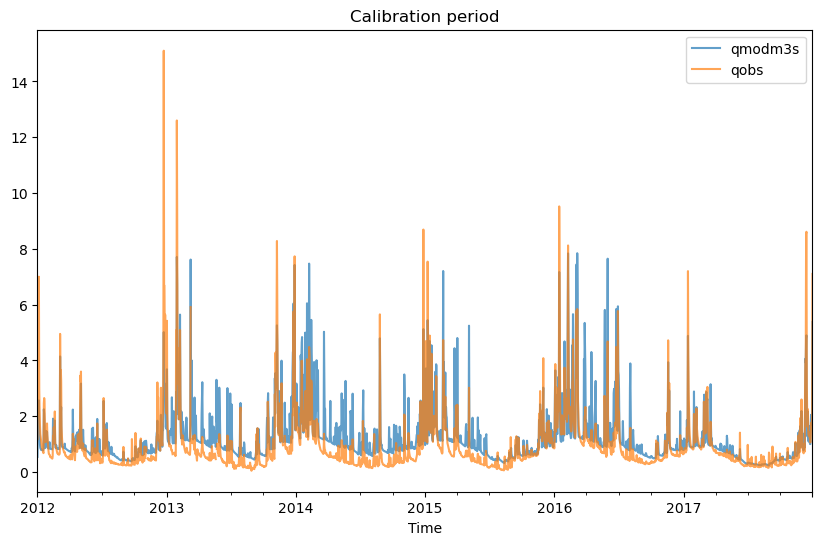

In [29]:
pd_zwalm_outp1_p1opt = PDM(P = p_zwalm_p1['P_thiessen'].values, 
    EP = ep_zwalm_p1['EP_thiessen'].values,
    t = p1_period.values, area = area_zwalm_new, deltat = deltat, deltatout = deltat_out ,
    parameters = p1_opt_parameters)#type:ignore

Q_day_join = Q_day.rename(columns = {'Time':'Timestamp','Value':'qobs'})
pd_zwalm_outp1_p1opt = pd_zwalm_outp1_p1opt.join(Q_day_join, on = 'Time', how = 'left')
pd_zwalm_outp1_p1opt = pd_zwalm_outp1_p1opt.set_index('Time')
fig, ax = plt.subplots(figsize = (10,6))
pd_zwalm_outp1_p1opt.plot(ax =ax,y = ['qmodm3s','qobs'], alpha = 0.7, title = 'Calibration period: NSE as measure')

nse_p1_p1opt = NSE(
    pd_zwalm_outp1_p1opt.loc[p1_period_excl_warmup, 'qmodm3s'],
    pd_zwalm_outp1_p1opt.loc[p1_period_excl_warmup, 'qobs']
)
mnse_p1_p1opt = mNSE(
    pd_zwalm_outp1_p1opt.loc[p1_period_excl_warmup, 'qmodm3s'],
    pd_zwalm_outp1_p1opt.loc[p1_period_excl_warmup, 'qobs']
)
print('NSE on calibration period p1  excluding warm-up: ' +str(nse_p1_p1opt))
print('mNSE on calibration period p1  excluding warm-up: ' +str(mnse_p1_p1opt))
print('-----------------------------------------------------------------------')
print('NSE on p1 for initial parameter set excluding warm-up:' + str(nse_initial_p1))
print('mNSE on p1 for initial set excluding warm-up:' + str(mnse_initial_p1))

Base flow is off...

Running model below on period 2 for validation

NSE on calibration period p2 excluding warm-up: 0.7470034639635559
mNSE on calibration period p2 excluding warm-up: 0.5240026274069189
------------------------------------------------------------------
NSE on p2 for initial set:0.7281982915863973
mNSE on p2 for initial set: 0.5272516896865588


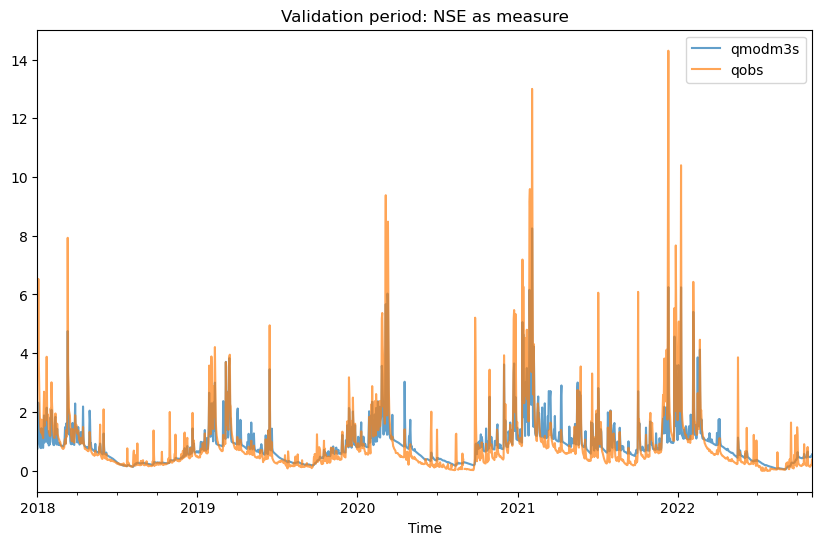

In [31]:
pd_zwalm_outp2_p1opt = PDM(P = p_zwalm_p2['P_thiessen'].values, 
    EP = ep_zwalm_p2['EP_thiessen'].values,
    t = p2_period.values, area = area_zwalm_new, deltat = deltat, deltatout = deltat_out ,
    parameters = p1_opt_parameters)#type:ignore
pd_zwalm_outp2_p1opt = pd_zwalm_outp2_p1opt.join(Q_day, on = 'Time', how = 'left')
pd_zwalm_outp2_p1opt = pd_zwalm_outp2_p1opt.set_index('Time')
fig, ax = plt.subplots(figsize = (10,6))
pd_zwalm_outp2_p1opt.plot(ax = ax, y = ['qmodm3s','qobs'], alpha = 0.7, title = 'Validation period: NSE as measure')

nse_p2_p1opt = NSE(
    pd_zwalm_outp2_p1opt.loc[p2_period_excl_warmup, 'qmodm3s'],
    pd_zwalm_outp2_p1opt.loc[p2_period_excl_warmup, 'qobs']
)
mnse_p2_p1opt = mNSE(
    pd_zwalm_outp2_p1opt.loc[p2_period_excl_warmup, 'qmodm3s'],
    pd_zwalm_outp2_p1opt.loc[p2_period_excl_warmup, 'qobs']
)
print('NSE on calibration period p2 excluding warm-up: ' +str(nse_p2_p1opt))
print('mNSE on calibration period p2 excluding warm-up: ' +str(mnse_p2_p1opt))
print('------------------------------------------------------------------')
print('NSE on p2 for initial set:' + str(nse_initial_p2))
print('mNSE on p2 for initial set: ' + str(mnse_initial_p2))


### Calibration on period 1, validation on period 2 with mNSE

In [49]:
goal_function_mNSE = lambda param: -PDM_calibration_wrapper(
    param, parameters_initial.columns, 'mNSE',p_zwalm_p1['P_thiessen'].values,
    ep_zwalm_p1['EP_thiessen'].values, area_zwalm_new, deltat,
    deltat_out, p1_period.values, p1_period_excl_warmup.values, Q_day['Value']
)
exec_optimisation = False
if exec_optimisation:
    optimize_result_p1_mNSE = scipy.optimize.minimize(
        goal_function_mNSE, init_reshaped, method = 'Nelder-Mead',
        callback = callback_personal, 
        options = {'xatol':0.01, 'fatol':0.001, 'maxiter':150}
    ) #has to be (n,) for initial valeus
# Read in and write out data
if exec_write:
    p1_opt_parameters_mNSE = pd.DataFrame(optimize_result_p1_mNSE.x.reshape(1,-1))#type:ignore
    p1_opt_parameters_mNSE.columns = parameters_initial.columns
    p1_opt_parameters_mNSE.to_csv('data/Zwalm_PDM_parameters/p1_opt_param_mNSE.csv')
if exec_read:
    p1_opt_parameters_mNSE = pd.read_csv('data/Zwalm_PDM_parameters/p1_opt_param_mNSE.csv')

In [56]:
print('mNSE optimised on p1')
display(p1_opt_parameters_mNSE[parameters_initial.columns])
print('Original')
display(parameters_initial)

mNSE optimised on p1


,cmax,cmin,b,be,k1,k2,kb,kg,St,bg,tdly,qconst
0,432.146951,96.959701,0.272994,3.540035,9.430386,0.682754,4.815894,9099.823493,0.467015,0.962715,2.038603,0.000438


Original


,cmax,cmin,b,be,k1,k2,kb,kg,St,bg,tdly,qconst
0,400.609985,87.676003,0.6,3.0,8.0,0.7,5.0466,9000.0,0.43043,1.0,2.0,0.0


NSE on calibration period p1  excluding warm-up: 0.4462829964787497
mNSE on calibration period p1  excluding warm-up: 0.31592639737442196
-----------------------------------------------------------------------
NSE on p1 for initial parameter set excluding warm-up:0.250914935432599
mNSE on p1 for initial set excluding warm-up:0.2441221681618948


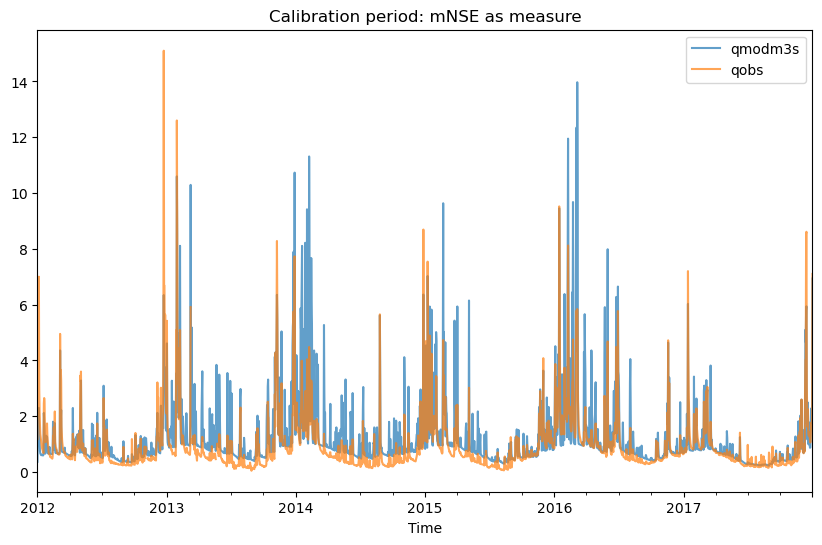

In [41]:
pd_zwalm_outp1_p1optmNSE = PDM(P = p_zwalm_p1['P_thiessen'].values, 
    EP = ep_zwalm_p1['EP_thiessen'].values,
    t = p1_period.values, area = area_zwalm_new, deltat = deltat, deltatout = deltat_out ,
    parameters = p1_opt_parameters_mNSE)#type:ignore

Q_day_join = Q_day.rename(columns = {'Time':'Timestamp','Value':'qobs'})
pd_zwalm_outp1_p1optmNSE = pd_zwalm_outp1_p1optmNSE.join(Q_day_join, on = 'Time', how = 'left')
pd_zwalm_outp1_p1optmNSE = pd_zwalm_outp1_p1optmNSE.set_index('Time')
fig, ax = plt.subplots(figsize = (10,6))
pd_zwalm_outp1_p1optmNSE.plot(ax =ax,y = ['qmodm3s','qobs'], alpha = 0.7, title = 'Calibration period: mNSE as measure')

nse_p1_p1optmNSE = NSE(
    pd_zwalm_outp1_p1optmNSE.loc[p1_period_excl_warmup, 'qmodm3s'],
    pd_zwalm_outp1_p1optmNSE.loc[p1_period_excl_warmup, 'qobs']
)
mnse_p1_p1optmNSE = mNSE(
    pd_zwalm_outp1_p1optmNSE.loc[p1_period_excl_warmup, 'qmodm3s'],
    pd_zwalm_outp1_p1optmNSE.loc[p1_period_excl_warmup, 'qobs']
)
print('NSE on calibration period p1  excluding warm-up: ' +str(nse_p1_p1optmNSE))
print('mNSE on calibration period p1  excluding warm-up: ' +str(mnse_p1_p1optmNSE))
print('-----------------------------------------------------------------------')
print('NSE on p1 for initial parameter set excluding warm-up:' + str(nse_initial_p1))
print('mNSE on p1 for initial set excluding warm-up:' + str(mnse_initial_p1))

NSE on calibration period p2 excluding warm-up: 0.8222948423083346
mNSE on calibration period p2 excluding warm-up: 0.5863181475595791
------------------------------------------------------------------
NSE on p2 for initial set:0.7281982915863973
mNSE on p2 for initial set: 0.5272516896865588


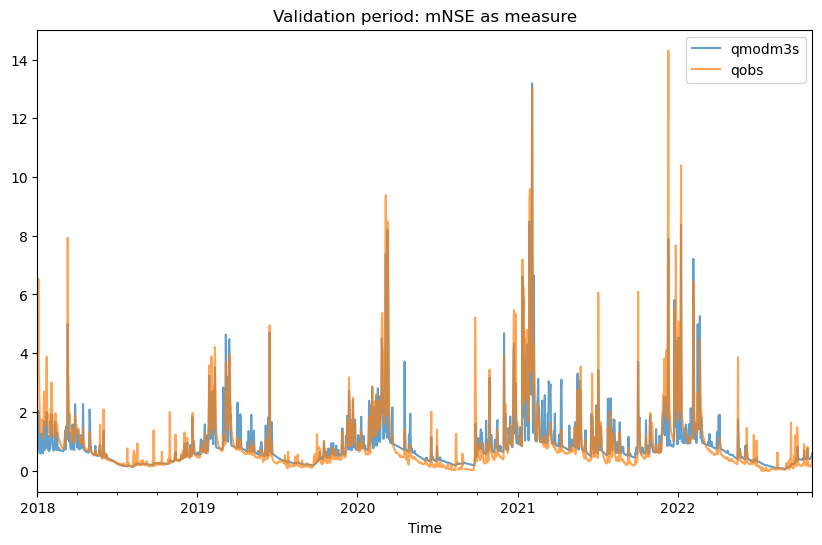

In [42]:
pd_zwalm_outp2_p1optmNSE = PDM(P = p_zwalm_p2['P_thiessen'].values, 
    EP = ep_zwalm_p2['EP_thiessen'].values,
    t = p2_period.values, area = area_zwalm_new, deltat = deltat, deltatout = deltat_out ,
    parameters = p1_opt_parameters_mNSE)#type:ignore
pd_zwalm_outp2_p1optmNSE = pd_zwalm_outp2_p1optmNSE.join(Q_day_join, on = 'Time', how = 'left')
pd_zwalm_outp2_p1optmNSE = pd_zwalm_outp2_p1optmNSE.set_index('Time')
fig, ax = plt.subplots(figsize = (10,6))
pd_zwalm_outp2_p1optmNSE.plot(ax = ax, y = ['qmodm3s','qobs'], alpha = 0.7, title = 'Validation period: mNSE as measure')

nse_p2_p1optmNSE = NSE(
    pd_zwalm_outp2_p1optmNSE.loc[p2_period_excl_warmup, 'qmodm3s'],
    pd_zwalm_outp2_p1optmNSE.loc[p2_period_excl_warmup, 'qobs']
)
mnse_p2_p1optmNSE = mNSE(
    pd_zwalm_outp2_p1optmNSE.loc[p2_period_excl_warmup, 'qmodm3s'],
    pd_zwalm_outp2_p1optmNSE.loc[p2_period_excl_warmup, 'qobs']
)
print('NSE on calibration period p2 excluding warm-up: ' +str(nse_p2_p1optmNSE))
print('mNSE on calibration period p2 excluding warm-up: ' +str(mnse_p2_p1optmNSE))
print('------------------------------------------------------------------')
print('NSE on p2 for initial set:' + str(nse_initial_p2))
print('mNSE on p2 for initial set: ' + str(mnse_initial_p2))
